In [2]:
%matplotlib inline

import numpy  as np
import matplotlib.pyplot as plt
import matplotlib.colors as mp_colors
import pandas as pd

import time

In [40]:
from antea.io.mc_io import load_mchits
from antea.io.mc_io import load_mcsns_response
import antea.database.load_db as db

In [94]:
## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue         = tableau20[0]
green        = tableau20[4]
red          = tableau20[6]
pink         = tableau20[7]
purple       = tableau20[8]
light_purple = tableau20[9]
brown        = tableau20[10]
grey         = tableau20[15]
color_nice   = '#029386'

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 12, 8

colors    = [blue, green, red, purple, brown, grey]
linestyle = ['-', '-.', ':','-','--', ':']

In [95]:
def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

In [96]:
import textwrap
from invisible_cities.evm.ic_containers   import Measurement
from invisible_cities.icaro.hst_functions import measurement_string

def gtext(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f mm
        $\sigma$ = %.3f +/- %.3f mm
        FWHM res. = %.3f mm
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

def gtext_angle(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = %.3f +/- %.3f deg
        $\sigma$ = %.3f +/- %.3f deg
        FWHM res. = %.3f deg
        """%(values[0] , errors[0],
             values[1] , errors[1], 2.35*values[1]))

In [97]:
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

## Load full MC

In [102]:
file_base = '/data5/users/carmenromo/fastmc/validation_matrices/data_files_from_full_sim/'

start         = 1000
numb_of_files = 100
df_full_all = pd.DataFrame({})
for file_number in range(start, start+numb_of_files):
    filename  = f'full_body_phantom_coincidences_phot_info_dist_tof_{file_number}_1_2_4_4_2.npz'
    file_name = file_base+filename
    try:
        d   = np.load(file_name)
        df0 = pd.DataFrame({})
        for (key, vals) in d.items():
            df0[key[2:]] = vals #2: is to avoid the name 'a_...' in the keys
        df_full_all = pd.concat((df_full_all, df0), ignore_index=True)
    except:
        print('File {} not found'.format(file_name))
        continue
        
print(len(df_full_all))

23585


In [103]:
df_full_all.head()

,true_r1,true_phi1,true_z1,true_r2,true_phi2,true_z2,reco_r1,reco_phi1,reco_z1,reco_r2,...,first_time2_thr2,true_time1,true_time2,photo1,photo2,photo_like1,photo_like2,hit_energy1,hit_energy2,event_ids
0,387.193315,-2.309582,204.739853,390.960479,0.810935,-78.465645,386.435883,-2.306855,204.083172,392.478058,...,1795.0,1499.404907,1262.661695,0.0,0.0,0.0,0.0,0.510999,0.510999,30000010.0
1,386.360718,2.489867,103.040283,386.520215,-0.579083,-216.999146,386.113159,2.487159,103.097899,400.122101,...,1870.0,1159.290075,1629.478335,0.0,0.0,1.0,0.0,0.510999,0.510999,30000011.0
2,382.067322,-2.399494,-280.982269,392.104884,0.583126,211.893494,381.075531,-2.395965,-281.041667,394.315552,...,1725.0,1753.679633,1300.738573,0.0,0.0,1.0,0.0,0.510999,0.510999,30000021.0
3,391.276666,-1.214835,64.822388,383.609180,1.983526,-136.211136,393.323273,-1.222601,66.297274,384.779327,...,2135.0,1099.119067,1570.197344,0.0,0.0,0.0,0.0,0.510999,0.510999,30000023.0
4,395.810700,0.323356,-198.688644,383.679225,-2.545249,160.214569,395.759521,0.323430,-198.430052,382.228271,...,1870.0,1596.257687,1244.269133,0.0,0.0,0.0,0.0,0.510999,0.510999,30000036.0


## Load fast MC

In [104]:
eventsPath    = '/data5/users/carmenromo/fastmc/validation_matrices/data_files_using_matrices/'

thrs = ['0.5', '1.0', '1.5']
cols = ['event_id', 'true_energy', 
        'true_r1', 'true_phi1', 'true_z1', 'true_t1', 
        'true_r2', 'true_phi2', 'true_z2', 'true_t2', 'phot_like1', 'phot_like2',
        'reco_r1', 'reco_phi1', 'reco_z1', 'reco_t1',
        'reco_r2', 'reco_phi2', 'reco_z2', 'reco_t2']

## We only take the events with energy above the energy threshold
df_fast_all_0 = pd.DataFrame(columns=cols)
df_fast_all_1 = pd.DataFrame(columns=cols)
df_fast_all_2 = pd.DataFrame(columns=cols)

for file_number in range(start, start+numb_of_files):
    for th in thrs:
        filename  = f'full_body_phantom_reco_thr{th}pes.{file_number}.h5'
        file_name = eventsPath+filename
        try:
            table = pd.read_hdf(file_name, 'reco/table')
            sel_below_th = (table.true_energy > 0.) & (table.true_r1 == 0.)
            reco = table[~sel_below_th]
            if th == '0.5':
                df_fast_all_0 = pd.concat([df_fast_all_0, reco], ignore_index=True)
            elif th == '1.0':
                df_fast_all_1 = pd.concat([df_fast_all_1, reco], ignore_index=True)
            elif th == '1.5':
                df_fast_all_2 = pd.concat([df_fast_all_2, reco], ignore_index=True)
        except:
            print('File {} not found'.format(filename))
            continue

File full_body_phantom_reco_thr0.5pes.1021.h5 not found
File full_body_phantom_reco_thr1.0pes.1021.h5 not found
File full_body_phantom_reco_thr1.5pes.1021.h5 not found
File full_body_phantom_reco_thr0.5pes.1027.h5 not found
File full_body_phantom_reco_thr1.0pes.1027.h5 not found
File full_body_phantom_reco_thr1.5pes.1027.h5 not found
File full_body_phantom_reco_thr0.5pes.1075.h5 not found
File full_body_phantom_reco_thr1.0pes.1075.h5 not found
File full_body_phantom_reco_thr1.5pes.1075.h5 not found


In [105]:
df_fast_all_0.head()

,event_id,index,phot_like1,phot_like2,reco_phi1,reco_phi2,reco_r1,reco_r2,reco_t1,reco_t2,...,reco_z2,true_energy,true_phi1,true_phi2,true_r1,true_r2,true_t1,true_t2,true_z1,true_z2
0,30000010.0,0.0,0.0,0.0,-2.268170,0.813638,392.601502,396.199921,1566.694590,1408.483296,...,-79.904829,1.021998,-2.309582,0.810935,387.193298,390.960480,1499.404907,1262.661695,204.739853,-78.465645
1,30000011.0,0.0,1.0,0.0,2.486806,-0.563731,385.917741,385.092019,1254.164274,1745.640968,...,-214.772415,1.021998,2.489867,-0.579083,386.360718,386.520203,1159.290075,1629.478335,103.040283,-216.999146
2,30000021.0,0.0,1.0,0.0,-2.396611,0.589033,382.486862,390.327715,2010.093055,1547.350676,...,209.022930,1.021998,-2.399494,0.583126,382.067322,392.104889,1753.679633,1300.738573,-280.982269,211.893494
3,30000023.0,0.0,0.0,0.0,-1.204375,1.986000,391.331118,393.139613,1343.404247,1607.654810,...,-129.620219,1.021998,-1.214835,1.983526,391.276642,383.609161,1099.119067,1570.197344,64.822388,-136.211136
4,30000036.0,0.0,0.0,0.0,0.370394,-2.564779,403.904472,384.626417,1692.399391,1351.003655,...,159.120568,1.021998,0.323356,-2.545249,395.810699,383.679230,1596.257687,1244.269133,-198.688644,160.214569


In [106]:
df_fast_all_1.head()

,event_id,index,phot_like1,phot_like2,reco_phi1,reco_phi2,reco_r1,reco_r2,reco_t1,reco_t2,...,reco_z2,true_energy,true_phi1,true_phi2,true_r1,true_r2,true_t1,true_t2,true_z1,true_z2
0,30000010.0,0.0,0.0,0.0,-2.315378,0.811060,386.677753,389.605580,1867.589532,1729.201606,...,-78.977121,1.021998,-2.309582,0.810935,387.193298,390.960480,1499.404907,1262.661695,204.739853,-78.465645
1,30000011.0,0.0,1.0,0.0,2.486963,-0.576864,386.954316,382.386615,1791.440151,1811.666629,...,-217.346068,1.021998,2.489867,-0.579083,386.360718,386.520203,1159.290075,1629.478335,103.040283,-216.999146
2,30000021.0,0.0,1.0,0.0,-2.399202,0.592431,381.311925,391.232814,1798.456084,1380.678110,...,211.014813,1.021998,-2.399494,0.583126,382.067322,392.104889,1753.679633,1300.738573,-280.982269,211.893494
3,30000023.0,0.0,0.0,0.0,-1.219357,1.986071,391.247768,391.467555,1378.696697,1727.985355,...,-145.437099,1.021998,-1.214835,1.983526,391.276642,383.609161,1099.119067,1570.197344,64.822388,-136.211136
4,30000036.0,0.0,0.0,0.0,0.327342,-2.571704,385.058750,394.830458,1806.584675,1534.806124,...,157.519802,1.021998,0.323356,-2.545249,395.810699,383.679230,1596.257687,1244.269133,-198.688644,160.214569


In [107]:
print(len(df_full_all), len(df_fast_all_0), len(df_fast_all_1), len(df_fast_all_2))

23585 23677 23677 23677


In [109]:
### find common events
events       = df_full_all  .event_ids
events_fast0 = df_fast_all_0.event_id
events_fast1 = df_fast_all_1.event_id
events_fast2 = df_fast_all_2.event_id

common0 = list(set(events_fast0).intersection(events))
common1 = list(set(events_fast1).intersection(events))
common2 = list(set(events_fast2).intersection(events))

print(len(common0), len(common0)/len(events))
print(len(common0), len(common0)/len(events_fast0))

print(len(common1), len(common1)/len(events))
print(len(common1), len(common1)/len(events_fast1))

print(len(common2), len(common2)/len(events))
print(len(common2), len(common2)/len(events_fast2))

df_full   = df_full_all  [df_full_all  .event_ids.isin(common0)]
df_fast_0 = df_fast_all_0[df_fast_all_0.event_id .isin(common0)]
df_fast_1 = df_fast_all_1[df_fast_all_1.event_id .isin(common0)]
df_fast_2 = df_fast_all_2[df_fast_all_2.event_id .isin(common0)]

#df_full_1 = df_full_all  [df_full_all  .event_ids.isin(common1)]
#df_fast_1 = df_fast_all_1[df_fast_all_1.event_id .isin(common1)]
#
#df_full_2 = df_full_all  [df_full_all  .event_ids.isin(common2)]
#df_fast_2 = df_fast_all_2[df_fast_all_2.event_id .isin(common2)]

## The three fast df have the same events, so we simplify the full

19001 0.8056391774432903
19001 0.802508763779195
19001 0.8056391774432903
19001 0.802508763779195
19001 0.8056391774432903
19001 0.802508763779195


In [110]:
print(common0[0])

30212098.0


In [111]:
print(len(df_full), len(df_fast_0), len(df_fast_1), len(df_fast_2))

19001 19001 19001 19001


In [112]:
## full_all information common events
true_r1   = df_full.true_r1.values
true_phi1 = df_full.true_phi1.values
true_z1   = df_full.true_z1.values
true_t1   = df_full.true_time1.values

reco_r1   = df_full.reco_r1.values
reco_phi1 = df_full.reco_phi1.values
reco_z1   = df_full.reco_z1.values
true_t2   = df_full.true_time2.values

true_r2   = df_full.true_r2.values
true_phi2 = df_full.true_phi2.values
true_z2   = df_full.true_z2.values

reco_r2   = df_full.reco_r2.values
reco_phi2 = df_full.reco_phi2.values
reco_z2   = df_full.reco_z2.values

first_sipm1_0 = df_full.first_sipm1_thr0.values
first_sipm2_0 = df_full.first_sipm2_thr0.values
sipm_t1_0     = df_full.first_time1_thr0.values
sipm_t2_0     = df_full.first_time2_thr0.values

first_sipm1_1 = df_full.first_sipm1_thr1.values
first_sipm2_1 = df_full.first_sipm2_thr1.values
sipm_t1_1     = df_full.first_time1_thr1.values
sipm_t2_1     = df_full.first_time2_thr1.values

first_sipm1_2 = df_full.first_sipm1_thr2.values
first_sipm2_2 = df_full.first_sipm2_thr2.values
sipm_t1_2     = df_full.first_time1_thr2.values
sipm_t2_2     = df_full.first_time2_thr2.values

sns_response1 = df_full.sns_response1.values
sns_response2 = df_full.sns_response2.values

events = df_full.event_ids.values

true_x1 = true_r1 * np.cos(true_phi1)
reco_x1 = reco_r1 * np.cos(reco_phi1)
true_y1 = true_r1 * np.sin(true_phi1)
reco_y1 = reco_r1 * np.sin(reco_phi1)
true_x2 = true_r2 * np.cos(true_phi2)
reco_x2 = reco_r2 * np.cos(reco_phi2)
true_y2 = true_r2 * np.sin(true_phi2)
reco_y2 = reco_r2 * np.sin(reco_phi2)

### change by hand phi reconstructed as true=~3.14, reco~=-3.14
reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.] = -reco_phi1[np.abs(reco_phi1 - true_phi1) > 6.]
reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.] = -reco_phi2[np.abs(reco_phi2 - true_phi2) > 6.]

diff_x1   = reco_x1 - true_x1
diff_y1   = reco_y1 - true_y1
diff_r1   = reco_r1 - true_r1
diff_phi1 = reco_phi1 - true_phi1
diff_z1   = reco_z1 - true_z1

diff_x2   = reco_x2 - true_x2
diff_y2   = reco_y2 - true_y2
diff_r2   = reco_r2 - true_r2
diff_phi2 = reco_phi2 - true_phi2
diff_z2   = reco_z2 - true_z2

### read sensor positions from database
DataSiPM     = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')
speed_in_vacuum = 0.299792458# * units.mm / units.ps
ave_speed_in_LXe = 0.210 #* units.mm / units.ps

# distances are saved in mm and times in ps
### Positions
pos_1 = np.array([reco_x1, reco_y1, reco_z1]).transpose()
pos_2 = np.array([reco_x2, reco_y2, reco_z2]).transpose()

sipm_pos_1_0 = np.array([DataSiPM_idx.loc[first_sipm1_0].X, DataSiPM_idx.loc[first_sipm1_0].Y, DataSiPM_idx.loc[first_sipm1_0].Z]).transpose()
sipm_pos_2_0 = np.array([DataSiPM_idx.loc[first_sipm2_0].X, DataSiPM_idx.loc[first_sipm2_0].Y, DataSiPM_idx.loc[first_sipm2_0].Z]).transpose()
sipm_pos_1_1 = np.array([DataSiPM_idx.loc[first_sipm1_1].X, DataSiPM_idx.loc[first_sipm1_1].Y, DataSiPM_idx.loc[first_sipm1_1].Z]).transpose()
sipm_pos_2_1 = np.array([DataSiPM_idx.loc[first_sipm2_1].X, DataSiPM_idx.loc[first_sipm2_1].Y, DataSiPM_idx.loc[first_sipm2_1].Z]).transpose()
sipm_pos_1_2 = np.array([DataSiPM_idx.loc[first_sipm1_2].X, DataSiPM_idx.loc[first_sipm1_2].Y, DataSiPM_idx.loc[first_sipm1_2].Z]).transpose()
sipm_pos_2_2 = np.array([DataSiPM_idx.loc[first_sipm2_2].X, DataSiPM_idx.loc[first_sipm2_2].Y, DataSiPM_idx.loc[first_sipm2_2].Z]).transpose()

### Distance of the interaction point from the SiPM seeing the first photon
dist1_0 = np.linalg.norm(np.subtract(pos_1, sipm_pos_1_0), axis=1)
dist2_0 = np.linalg.norm(np.subtract(pos_2, sipm_pos_2_0), axis=1)
dist1_1 = np.linalg.norm(np.subtract(pos_1, sipm_pos_1_1), axis=1)
dist2_1 = np.linalg.norm(np.subtract(pos_2, sipm_pos_2_1), axis=1)
dist1_2 = np.linalg.norm(np.subtract(pos_1, sipm_pos_1_2), axis=1)
dist2_2 = np.linalg.norm(np.subtract(pos_2, sipm_pos_2_2), axis=1)

reco_t1_0 = sipm_t1_0 - (dist1_0/ave_speed_in_LXe)
reco_t2_0 = sipm_t2_0 - (dist2_0/ave_speed_in_LXe)
reco_t1_1 = sipm_t1_1 - (dist1_1/ave_speed_in_LXe)
reco_t2_1 = sipm_t2_1 - (dist2_1/ave_speed_in_LXe)
reco_t1_2 = sipm_t1_2 - (dist1_2/ave_speed_in_LXe)
reco_t2_2 = sipm_t2_2 - (dist2_2/ave_speed_in_LXe)

In [113]:
## fast information
true_r1_fast_0    = df_fast_0.true_r1   .values
true_phi1_fast_0  = df_fast_0.true_phi1 .values
true_z1_fast_0    = df_fast_0.true_z1   .values
true_t1_fast_0    = df_fast_0.true_t1   .values
reco_r1_fast_0    = df_fast_0.reco_r1   .values
reco_phi1_fast_0  = df_fast_0.reco_phi1 .values
reco_z1_fast_0    = df_fast_0.reco_z1   .values
reco_t1_fast_0    = df_fast_0.reco_t1   .values
true_r2_fast_0    = df_fast_0.true_r2   .values
true_phi2_fast_0  = df_fast_0.true_phi2 .values
true_z2_fast_0    = df_fast_0.true_z2   .values
true_t2_fast_0    = df_fast_0.true_t2   .values
reco_r2_fast_0    = df_fast_0.reco_r2   .values
reco_phi2_fast_0  = df_fast_0.reco_phi2 .values
reco_z2_fast_0    = df_fast_0.reco_z2   .values
reco_t2_fast_0    = df_fast_0.reco_t2   .values
events_fast_0     = df_fast_0.event_id  .values
phot_like1_fast_0 = df_fast_0.phot_like1.values
phot_like2_fast_0 = df_fast_0.phot_like2.values

true_r1_fast_1    = df_fast_1.true_r1   .values
true_phi1_fast_1  = df_fast_1.true_phi1 .values
true_z1_fast_1    = df_fast_1.true_z1   .values
true_t1_fast_1    = df_fast_1.true_t1   .values
reco_r1_fast_1    = df_fast_1.reco_r1   .values
reco_phi1_fast_1  = df_fast_1.reco_phi1 .values
reco_z1_fast_1    = df_fast_1.reco_z1   .values
reco_t1_fast_1    = df_fast_1.reco_t1   .values
true_r2_fast_1    = df_fast_1.true_r2   .values
true_phi2_fast_1  = df_fast_1.true_phi2 .values
true_z2_fast_1    = df_fast_1.true_z2   .values
true_t2_fast_1    = df_fast_1.true_t2   .values
reco_r2_fast_1    = df_fast_1.reco_r2   .values
reco_phi2_fast_1  = df_fast_1.reco_phi2 .values
reco_z2_fast_1    = df_fast_1.reco_z2   .values
reco_t2_fast_1    = df_fast_1.reco_t2   .values
events_fast_1     = df_fast_1.event_id  .values
phot_like1_fast_1 = df_fast_1.phot_like1.values
phot_like2_fast_1 = df_fast_1.phot_like2.values

true_r1_fast_2    = df_fast_2.true_r1   .values
true_phi1_fast_2  = df_fast_2.true_phi1 .values
true_z1_fast_2    = df_fast_2.true_z1   .values
true_t1_fast_2    = df_fast_2.true_t1   .values
reco_r1_fast_2    = df_fast_2.reco_r1   .values
reco_phi1_fast_2  = df_fast_2.reco_phi1 .values
reco_z1_fast_2    = df_fast_2.reco_z1   .values
reco_t1_fast_2    = df_fast_2.reco_t1   .values
true_r2_fast_2    = df_fast_2.true_r2   .values
true_phi2_fast_2  = df_fast_2.true_phi2 .values
true_z2_fast_2    = df_fast_2.true_z2   .values
true_t2_fast_2    = df_fast_2.true_t2   .values
reco_r2_fast_2    = df_fast_2.reco_r2   .values
reco_phi2_fast_2  = df_fast_2.reco_phi2 .values
reco_z2_fast_2    = df_fast_2.reco_z2   .values
reco_t2_fast_2    = df_fast_2.reco_t2   .values
events_fast_2     = df_fast_2.event_id  .values
phot_like1_fast_2 = df_fast_2.phot_like1.values
phot_like2_fast_2 = df_fast_2.phot_like2.values

In [114]:
print(len(sipm_t1_0), len(reco_r1), len(true_t1))

19001 19001 19001


In [115]:
len(true_t1_fast_0)

19001

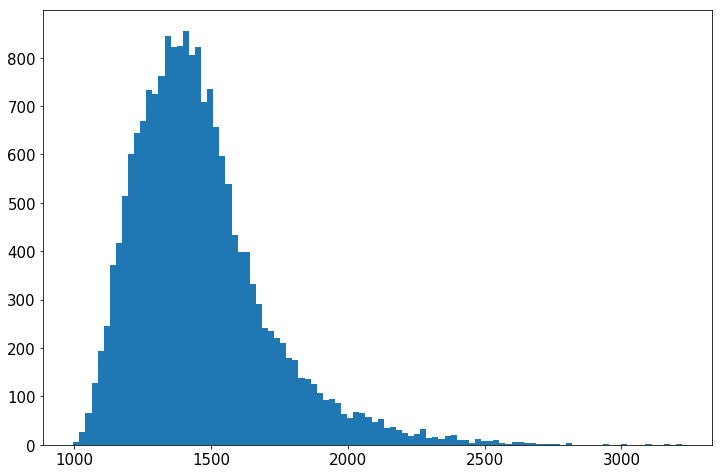

In [120]:
h=plt.hist(true_t1_fast_0, bins=100);
#h1=plt.hist(true_t1_fast_1, bins=100, histtype='step');
#h2=plt.hist(true_t1_fast_2, bins=100, histtype='step');

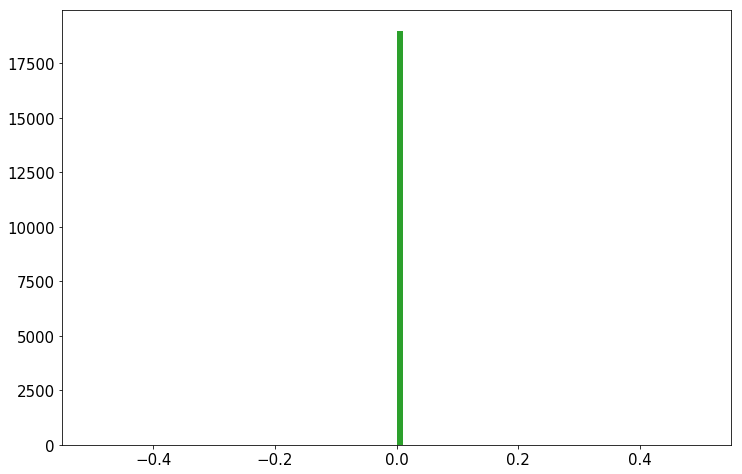

In [121]:
h = plt.hist(true_t2 - true_t2_fast_0, bins=100);
h = plt.hist(true_t2 - true_t2_fast_1, bins=100);
h = plt.hist(true_t2 - true_t2_fast_2, bins=100);
#plt.xlim(1000, 3000)
#plt.ylim(0, 300)

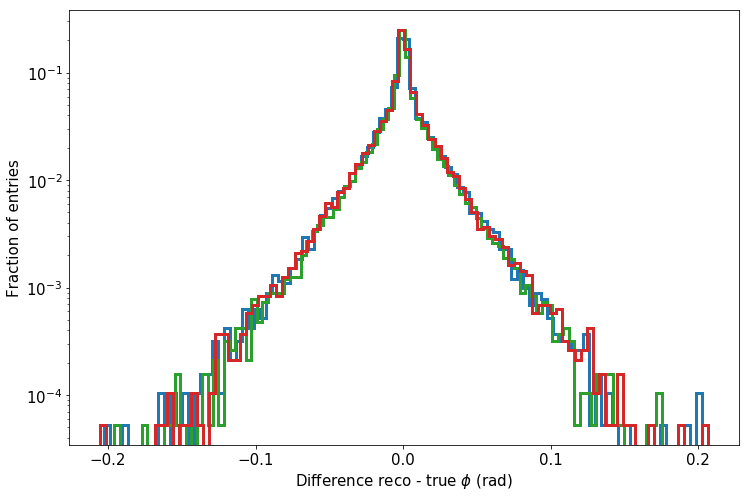

In [126]:
bins = 100
weights0 = get_weights(reco_phi1 - reco_phi1_fast_0, True)
weights1 = get_weights(reco_phi1 - reco_phi1_fast_1, True)
weights2 = get_weights(reco_phi1 - reco_phi1_fast_0, True)
h0 = plt.hist(reco_phi1 - reco_phi1_fast_0, bins=bins, color=colors[0], histtype='step', weights=weights0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0])
h1 = plt.hist(reco_phi1 - reco_phi1_fast_1, bins=bins, color=colors[1], histtype='step', weights=weights1,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(reco_phi1 - reco_phi1_fast_2, bins=bins, color=colors[2], histtype='step', weights=weights2,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0])
plt.xlabel('Difference reco - true $\phi$ (rad)')
plt.ylabel('Fraction of entries');
plt.yscale('log')

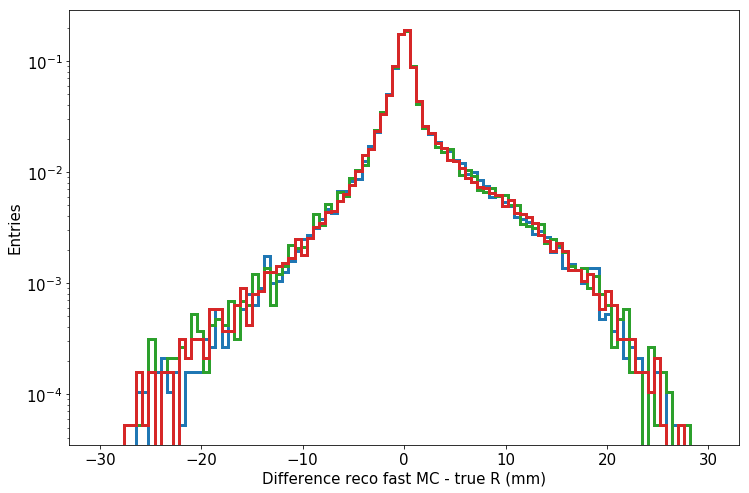

In [128]:
bins = 100
weights0 = get_weights(reco_r1_fast_0 - true_r1_fast_0, True)
weights1 = get_weights(reco_r1_fast_1 - true_r1_fast_1, True)
weights2 = get_weights(reco_r1_fast_2 - true_r1_fast_2, True)
h0 = plt.hist(reco_r1_fast_0 - true_r1_fast_0, bins=bins, color=colors[0], range=(-30, 30), histtype='step',
              weights=weights0, stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0])
h1 = plt.hist(reco_r1_fast_1 - true_r1_fast_1, bins=bins, color=colors[1], range=(-30, 30), histtype='step',
              weights=weights1, stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(reco_r1_fast_2 - true_r1_fast_2, bins=bins, color=colors[2], range=(-30, 30), histtype='step',
              weights=weights2, stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0])
plt.xlabel('Difference reco fast MC - true R (mm)')
plt.ylabel('Entries');
plt.yscale('log')

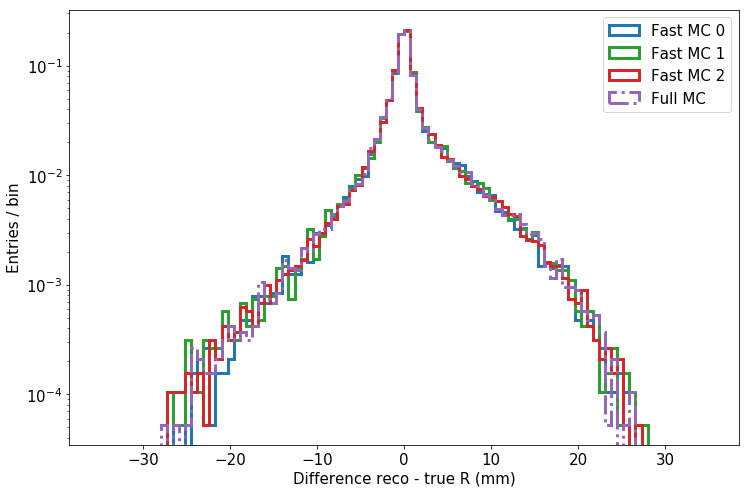

In [135]:
bins  = 100
full  = reco_r1 - true_r1
fast0 = reco_r1_fast_0 - true_r1_fast_0
fast1 = reco_r1_fast_1 - true_r1_fast_1
fast2 = reco_r1_fast_2 - true_r1_fast_2

bins0 = np.histogram(np.hstack((full, fast0)), bins=100, range=(-35, 35))[1] #get the bin edges
bins1 = np.histogram(np.hstack((full, fast1)), bins=100, range=(-35, 35))[1] #get the bin edges
bins2 = np.histogram(np.hstack((full, fast2)), bins=100, range=(-35, 35))[1] #get the bin edges

weights_full  = get_weights(full,  True)
weights_fast0 = get_weights(fast0, True)
weights_fast1 = get_weights(fast1, True)
weights_fast2 = get_weights(fast2, True)
h0 = plt.hist(fast0, bins=bins0, color=colors[0], range=(-30, 30), histtype='step', weights=weights_fast0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 0')
h1 = plt.hist(fast1, bins=bins1, color=colors[1], range=(-30, 30), histtype='step', weights=weights_fast1,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1')
h2 = plt.hist(fast2, bins=bins2, color=colors[2], range=(-30, 30), histtype='step', weights=weights_fast2,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 2')
h4 = plt.hist(full, bins=bins0, color=colors[3], range=(-30, 30), histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true R (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=1)

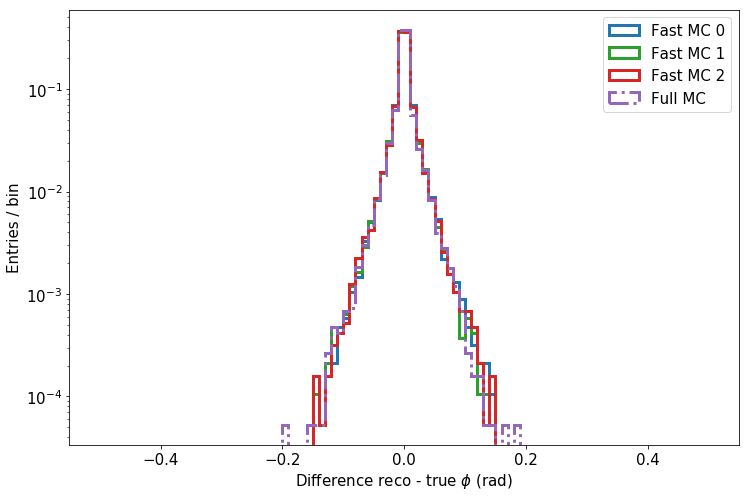

In [134]:
bins  = 100
full  = reco_phi1 - true_phi1
fast0 = reco_phi1_fast_0 - true_phi1_fast_0
fast1 = reco_phi1_fast_1 - true_phi1_fast_1
fast2 = reco_phi1_fast_2 - true_phi1_fast_2

bins0 = np.histogram(np.hstack((full, fast0)), bins=100, range=(-0.5, 0.5))[1] #get the bin edges
bins1 = np.histogram(np.hstack((full, fast1)), bins=100, range=(-0.5, 0.5))[1] #get the bin edges
bins2 = np.histogram(np.hstack((full, fast2)), bins=100, range=(-0.5, 0.5))[1] #get the bin edges

weights_full  = get_weights(full,  True)
weights_fast0 = get_weights(fast0, True)
weights_fast1 = get_weights(fast1, True)
weights_fast2 = get_weights(fast2, True)
h0 = plt.hist(fast0, bins=bins0, color=colors[0], histtype='step', weights=weights_fast0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 0')
h1 = plt.hist(fast1, bins=bins1, color=colors[1], histtype='step', weights=weights_fast1,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1')
h2 = plt.hist(fast2, bins=bins2, color=colors[2], histtype='step', weights=weights_fast2,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 2')
h4 = plt.hist(full, bins=bins0, color=colors[3], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true $\phi$ (rad)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=1)

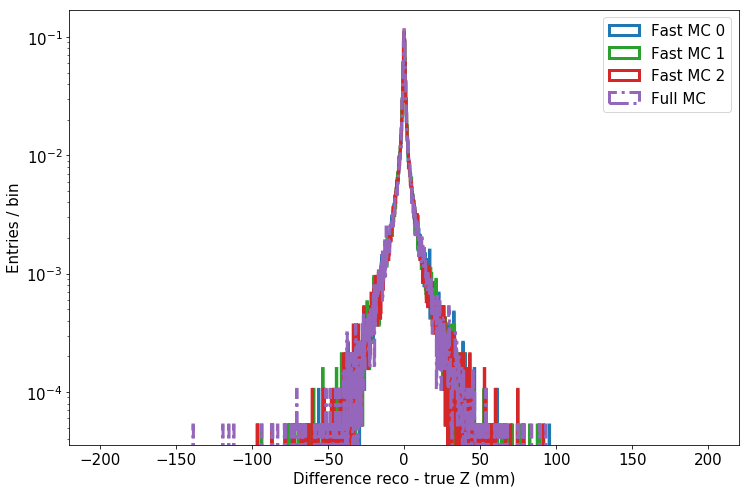

In [137]:
bins  = 100
full  = reco_z1 - true_z1
fast0 = reco_z1_fast_0 - true_z1_fast_0
fast1 = reco_z1_fast_1 - true_z1_fast_1
fast2 = reco_z1_fast_2 - true_z1_fast_2

bins0 = np.histogram(np.hstack((full, fast0)), bins=1333, range=(-200, 200))[1] #get the bin edges
bins1 = np.histogram(np.hstack((full, fast1)), bins=1333, range=(-200, 200))[1] #get the bin edges
bins2 = np.histogram(np.hstack((full, fast2)), bins=1333, range=(-200, 200))[1] #get the bin edges

weights_full  = get_weights(full,  True)
weights_fast0 = get_weights(fast0, True)
weights_fast1 = get_weights(fast1, True)
weights_fast2 = get_weights(fast2, True)
h0 = plt.hist(fast0, bins=bins0, color=colors[0], histtype='step', weights=weights_fast0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 0')
h1 = plt.hist(fast1, bins=bins1, color=colors[1], histtype='step', weights=weights_fast1,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1')
h2 = plt.hist(fast2, bins=bins2, color=colors[2], histtype='step', weights=weights_fast2,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 2')
h4 = plt.hist(full, bins=bins0, color=colors[3], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true Z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=1)

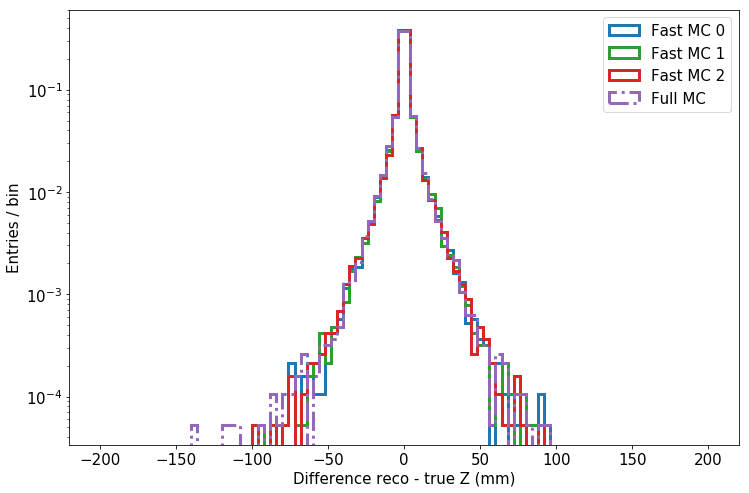

In [138]:
bins  = 100
full  = reco_z1 - true_z1
fast0 = reco_z1_fast_0 - true_z1_fast_0
fast1 = reco_z1_fast_1 - true_z1_fast_1
fast2 = reco_z1_fast_2 - true_z1_fast_2

bins0 = np.histogram(np.hstack((full, fast0)), bins=100, range=(-200, 200))[1] #get the bin edges
bins1 = np.histogram(np.hstack((full, fast1)), bins=100, range=(-200, 200))[1] #get the bin edges
bins2 = np.histogram(np.hstack((full, fast2)), bins=100, range=(-200, 200))[1] #get the bin edges

weights_full  = get_weights(full,  True)
weights_fast0 = get_weights(fast0, True)
weights_fast1 = get_weights(fast1, True)
weights_fast2 = get_weights(fast2, True)
h0 = plt.hist(fast0, bins=bins0, color=colors[0], histtype='step', weights=weights_fast0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 0')
h1 = plt.hist(fast1, bins=bins1, color=colors[1], histtype='step', weights=weights_fast1,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1')
h2 = plt.hist(fast2, bins=bins2, color=colors[2], histtype='step', weights=weights_fast2,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 2')
h4 = plt.hist(full, bins=bins0, color=colors[3], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true Z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=1)

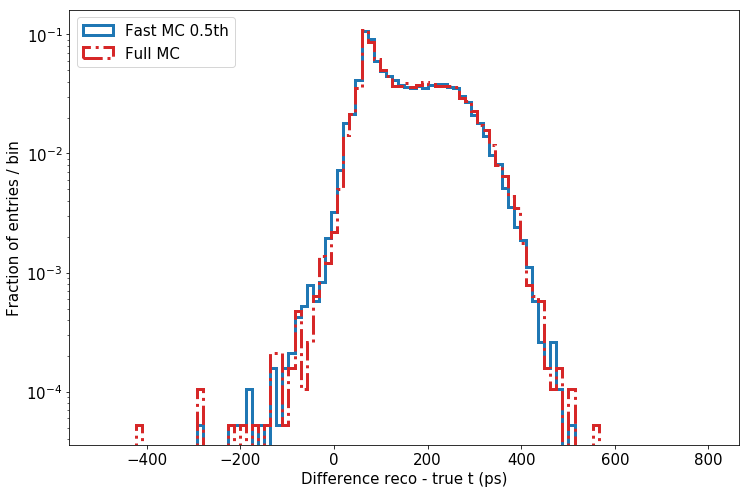

In [145]:
bins = 100
full = reco_t1_0 - true_t1
fast = reco_t1_fast_0 - true_t1_fast_0

bins = np.histogram(np.hstack((full, fast)),
                    range=(-500, 800), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 0.5th')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true t (ps)')
plt.ylabel('Fraction of entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

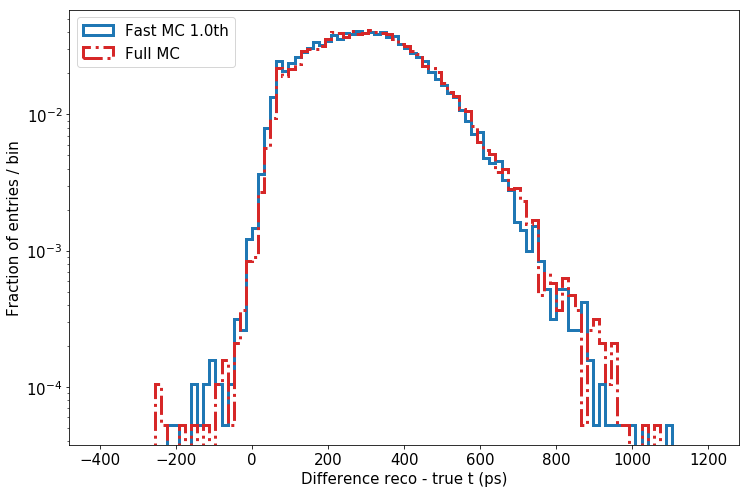

In [148]:
bins = 100
full = reco_t1_1 - true_t1
fast = reco_t1_fast_1 - true_t1_fast_1

bins = np.histogram(np.hstack((full, fast)),
                    range=(-400, 1200), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1.0th')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true t (ps)')
plt.ylabel('Fraction of entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

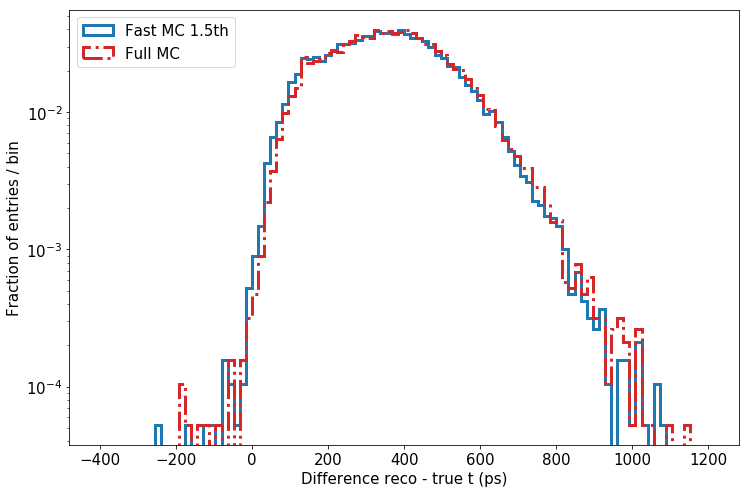

In [150]:
bins = 100
full = reco_t1_2 - true_t1
fast = reco_t1_fast_2 - true_t1_fast_2

bins = np.histogram(np.hstack((full, fast)),
                    range=(-400, 1200), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1.5th')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true t (ps)')
plt.ylabel('Fraction of entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

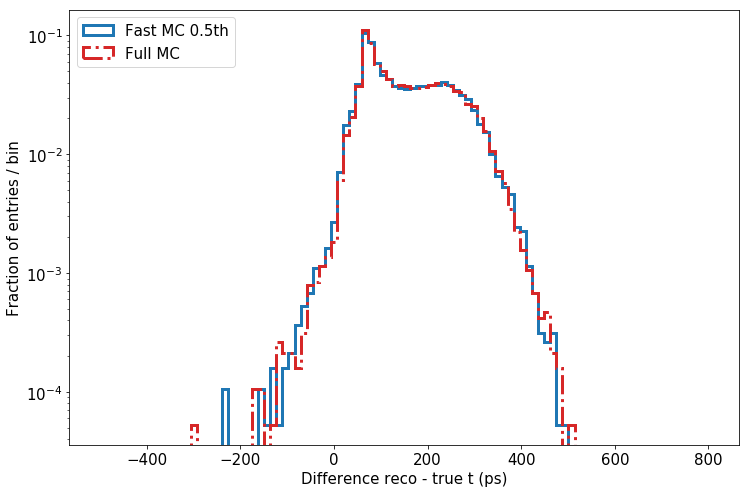

In [151]:
bins = 100
full = reco_t2_0 - true_t2
fast = reco_t2_fast_0 - true_t2_fast_0

bins = np.histogram(np.hstack((full, fast)),
                    range=(-500, 800), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 0.5th')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true t (ps)')
plt.ylabel('Fraction of entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

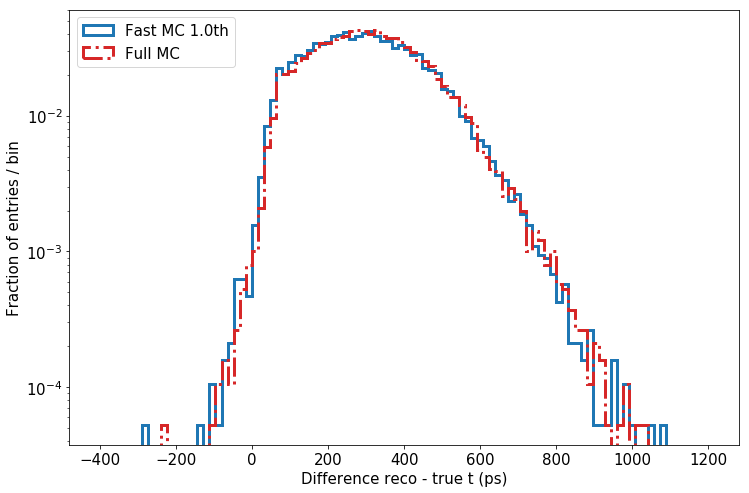

In [152]:
bins = 100
full = reco_t2_1 - true_t2
fast = reco_t2_fast_1 - true_t2_fast_1

bins = np.histogram(np.hstack((full, fast)),
                    range=(-400, 1200), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1.0th')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true t (ps)')
plt.ylabel('Fraction of entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

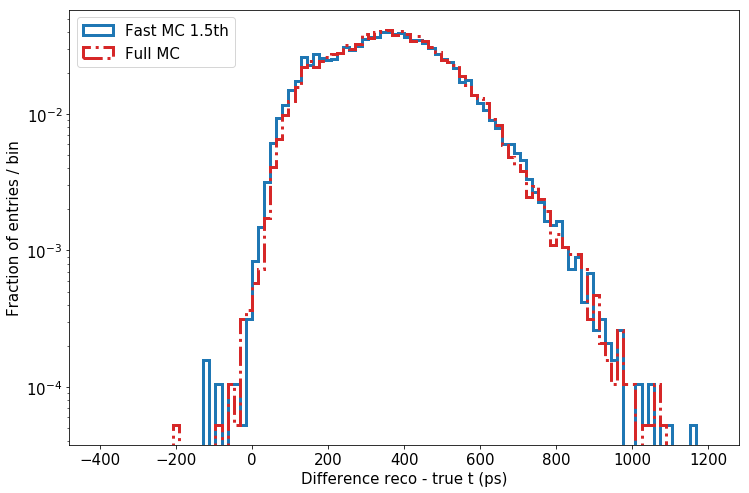

In [153]:
bins = 100
full = reco_t2_2 - true_t2
fast = reco_t2_fast_2 - true_t2_fast_2

bins = np.histogram(np.hstack((full, fast)),
                    range=(-400, 1200), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full = get_weights(full, True)
weights_fast = get_weights(fast, True)
h0 = plt.hist(fast, bins=bins, color=colors[0], histtype='step', weights=weights_fast,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1.5th')
h1 = plt.hist(full, bins=bins, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true t (ps)')
plt.ylabel('Fraction of entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

In [158]:
phot1_df0 = df_fast_all_0[df_fast_all_0.phot_like1>0]
phot2_df0 = df_fast_all_0[df_fast_all_0.phot_like2>0]
phot1_df1 = df_fast_all_1[df_fast_all_1.phot_like1>0]
phot2_df1 = df_fast_all_1[df_fast_all_1.phot_like2>0]
phot1_df2 = df_fast_all_2[df_fast_all_2.phot_like1>0]
phot2_df2 = df_fast_all_2[df_fast_all_2.phot_like2>0]

## fast_esel information
true_r1_phot_fast_0  , true_r1_phot_fast_1  , true_r1_phot_fast_2   = phot1_df0.true_r1.values,   phot1_df1.true_r1.values,   phot1_df2.true_r1.values
true_phi1_phot_fast_0, true_phi1_phot_fast_1, true_phi1_phot_fast_2 = phot1_df0.true_phi1.values, phot1_df1.true_phi1.values, phot1_df2.true_phi1.values
true_z1_phot_fast_0  , true_z1_phot_fast_1  , true_z1_phot_fast_2   = phot1_df0.true_z1.values,   phot1_df1.true_z1.values,   phot1_df2.true_z1.values
true_t1_phot_fast_0  , true_t1_phot_fast_1  , true_t1_phot_fast_2   = phot1_df0.true_t1.values,   phot1_df1.true_t1.values,   phot1_df2.true_t1.values
reco_r1_phot_fast_0  , reco_r1_phot_fast_1  , reco_r1_phot_fast_2   = phot1_df0.reco_r1.values,   phot1_df1.reco_r1.values,   phot1_df2.reco_r1.values
reco_phi1_phot_fast_0, reco_phi1_phot_fast_1, reco_phi1_phot_fast_2 = phot1_df0.reco_phi1.values, phot1_df1.reco_phi1.values, phot1_df2.reco_phi1.values
reco_z1_phot_fast_0  , reco_z1_phot_fast_1  , reco_z1_phot_fast_2   = phot1_df0.reco_z1.values,   phot1_df1.reco_z1.values,   phot1_df2.reco_z1.values
reco_t1_phot_fast_0  , reco_t1_phot_fast_1  , reco_t1_phot_fast_2   = phot1_df0.reco_t1.values,   phot1_df1.reco_t1.values,   phot1_df2.reco_t1.values
true_r2_phot_fast_0  , true_r2_phot_fast_1  , true_r2_phot_fast_2   = phot2_df0.true_r2.values,   phot2_df1.true_r2.values,   phot2_df2.true_r2.values
true_phi2_phot_fast_0, true_phi2_phot_fast_1, true_phi2_phot_fast_2 = phot2_df0.true_phi2.values, phot2_df1.true_phi2.values, phot2_df2.true_phi2.values
true_z2_phot_fast_0  , true_z2_phot_fast_1  , true_z2_phot_fast_2   = phot2_df0.true_z2.values,   phot2_df1.true_z2.values,   phot2_df2.true_z2.values
true_t2_phot_fast_0  , true_t2_phot_fast_1  , true_t2_phot_fast_2   = phot2_df0.true_t2.values,   phot2_df1.true_t2.values,   phot2_df2.true_t2.values
reco_r2_phot_fast_0  , reco_r2_phot_fast_1  , reco_r2_phot_fast_2   = phot2_df0.reco_r2.values,   phot2_df1.reco_r2.values,   phot2_df2.reco_r2.values
reco_phi2_phot_fast_0, reco_phi2_phot_fast_1, reco_phi2_phot_fast_2 = phot2_df0.reco_phi2.values, phot2_df1.reco_phi2.values, phot2_df2.reco_phi2.values
reco_z2_phot_fast_0  , reco_z2_phot_fast_1  , reco_z2_phot_fast_2   = phot2_df0.reco_z2.values,   phot2_df1.reco_z2.values,   phot2_df2.reco_z2.values
reco_t2_phot_fast_0  , reco_t2_phot_fast_1  , reco_t2_phot_fast_2   = phot2_df0.reco_t2.values,   phot2_df1.reco_t2.values,   phot2_df2.reco_t2.values

In [159]:
compt1_df0 = df_fast_all_0[df_fast_all_0.phot_like1==0]
compt2_df0 = df_fast_all_0[df_fast_all_0.phot_like2==0]
compt1_df1 = df_fast_all_1[df_fast_all_1.phot_like1==0]
compt2_df1 = df_fast_all_1[df_fast_all_1.phot_like2==0]
compt1_df2 = df_fast_all_2[df_fast_all_2.phot_like1==0]
compt2_df2 = df_fast_all_2[df_fast_all_2.phot_like2==0]

## fast_esel information
true_r1_compt_fast_0  , true_r1_compt_fast_1  , true_r1_compt_fast_2   = compt1_df0.true_r1.values,   compt1_df1.true_r1.values,   compt1_df2.true_r1.values
true_phi1_compt_fast_0, true_phi1_compt_fast_1, true_phi1_compt_fast_2 = compt1_df0.true_phi1.values, compt1_df1.true_phi1.values, compt1_df2.true_phi1.values
true_z1_compt_fast_0  , true_z1_compt_fast_1  , true_z1_compt_fast_2   = compt1_df0.true_z1.values,   compt1_df1.true_z1.values,   compt1_df2.true_z1.values
true_t1_compt_fast_0  , true_t1_compt_fast_1  , true_t1_compt_fast_2   = compt1_df0.true_t1.values,   compt1_df1.true_t1.values,   compt1_df2.true_t1.values
reco_r1_compt_fast_0  , reco_r1_compt_fast_1  , reco_r1_compt_fast_2   = compt1_df0.reco_r1.values,   compt1_df1.reco_r1.values,   compt1_df2.reco_r1.values
reco_phi1_compt_fast_0, reco_phi1_compt_fast_1, reco_phi1_compt_fast_2 = compt1_df0.reco_phi1.values, compt1_df1.reco_phi1.values, compt1_df2.reco_phi1.values
reco_z1_compt_fast_0  , reco_z1_compt_fast_1  , reco_z1_compt_fast_2   = compt1_df0.reco_z1.values,   compt1_df1.reco_z1.values,   compt1_df2.reco_z1.values
reco_t1_compt_fast_0  , reco_t1_compt_fast_1  , reco_t1_compt_fast_2   = compt1_df0.reco_t1.values,   compt1_df1.reco_t1.values,   compt1_df2.reco_t1.values
true_r2_compt_fast_0  , true_r2_compt_fast_1  , true_r2_compt_fast_2   = compt2_df0.true_r2.values,   compt2_df1.true_r2.values,   compt2_df2.true_r2.values
true_phi2_compt_fast_0, true_phi2_compt_fast_1, true_phi2_compt_fast_2 = compt2_df0.true_phi2.values, compt2_df1.true_phi2.values, compt2_df2.true_phi2.values
true_z2_compt_fast_0  , true_z2_compt_fast_1  , true_z2_compt_fast_2   = compt2_df0.true_z2.values,   compt2_df1.true_z2.values,   compt2_df2.true_z2.values
true_t2_compt_fast_0  , true_t2_compt_fast_1  , true_t2_compt_fast_2   = compt2_df0.true_t2.values,   compt2_df1.true_t2.values,   compt2_df2.true_t2.values
reco_r2_compt_fast_0  , reco_r2_compt_fast_1  , reco_r2_compt_fast_2   = compt2_df0.reco_r2.values,   compt2_df1.reco_r2.values,   compt2_df2.reco_r2.values
reco_phi2_compt_fast_0, reco_phi2_compt_fast_1, reco_phi2_compt_fast_2 = compt2_df0.reco_phi2.values, compt2_df1.reco_phi2.values, compt2_df2.reco_phi2.values
reco_z2_compt_fast_0  , reco_z2_compt_fast_1  , reco_z2_compt_fast_2   = compt2_df0.reco_z2.values,   compt2_df1.reco_z2.values,   compt2_df2.reco_z2.values
reco_t2_compt_fast_0  , reco_t2_compt_fast_1  , reco_t2_compt_fast_2   = compt2_df0.reco_t2.values,   compt2_df1.reco_t2.values,   compt2_df2.reco_t2.values

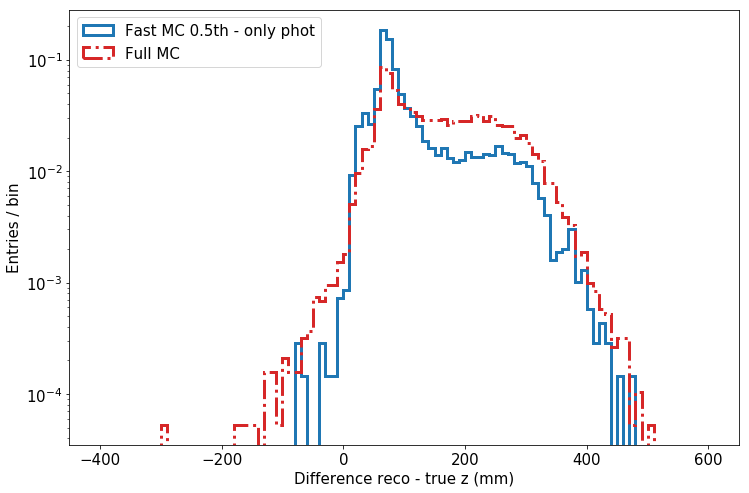

In [170]:
bins = 100
full0 = reco_t2_0 - true_t2
fast0 = reco_t2_phot_fast_0 - true_t2_phot_fast_0

bins0 = np.histogram(np.hstack((full0, fast0)), range=(-400,600), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full  = get_weights(full0, True)
weights_fast0 = get_weights(fast0, True)

h0 = plt.hist(fast0, bins=bins0, color=colors[0], histtype='step', weights=weights_fast0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 0.5th - only phot')
h1 = plt.hist(full0, bins=bins0, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

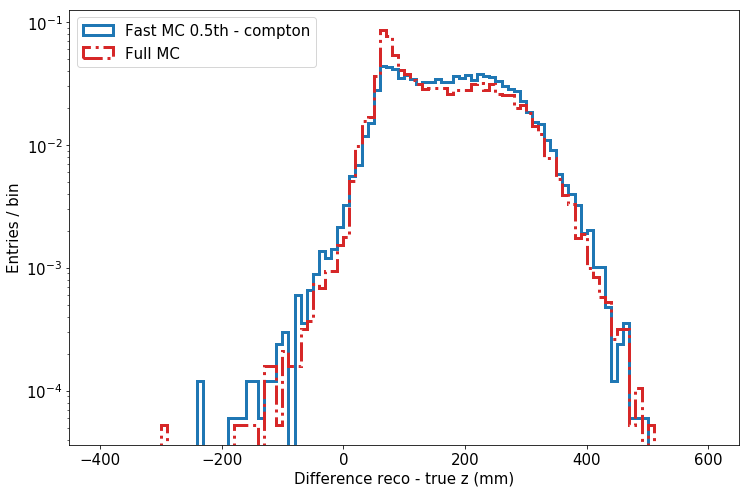

In [176]:
bins = 100
full0 = reco_t2_0 - true_t2
fast0 = reco_t2_compt_fast_0 - true_t2_compt_fast_0

bins0 = np.histogram(np.hstack((full0, fast0)), range=(-400,600), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full  = get_weights(full0, True)
weights_fast0 = get_weights(fast0, True)

h0 = plt.hist(fast0, bins=bins0, color=colors[0], histtype='step', weights=weights_fast0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 0.5th - compton')
h1 = plt.hist(full0, bins=bins0, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

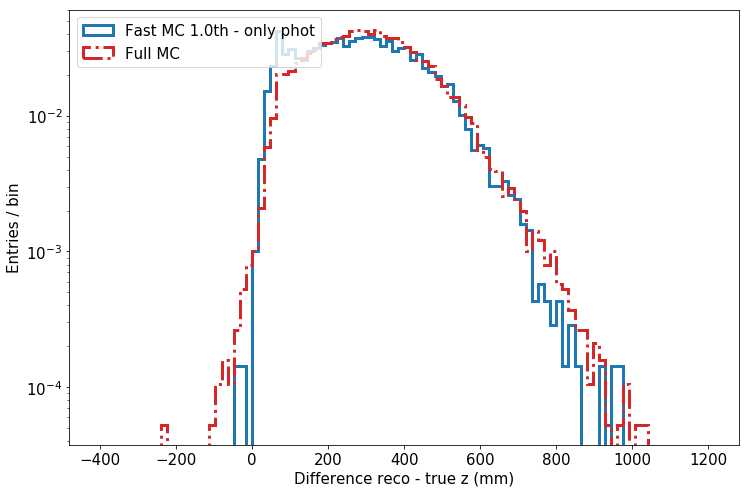

In [175]:
bins = 100
full1 = reco_t2_1 - true_t2
fast1 = reco_t2_phot_fast_1 - true_t2_phot_fast_1

bins1 = np.histogram(np.hstack((full1, fast1)), range=(-400,1200), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full  = get_weights(full1, True)
weights_fast0 = get_weights(fast1, True)

h0 = plt.hist(fast1, bins=bins1, color=colors[0], histtype='step', weights=weights_fast0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1.0th - only phot')
h1 = plt.hist(full1, bins=bins1, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

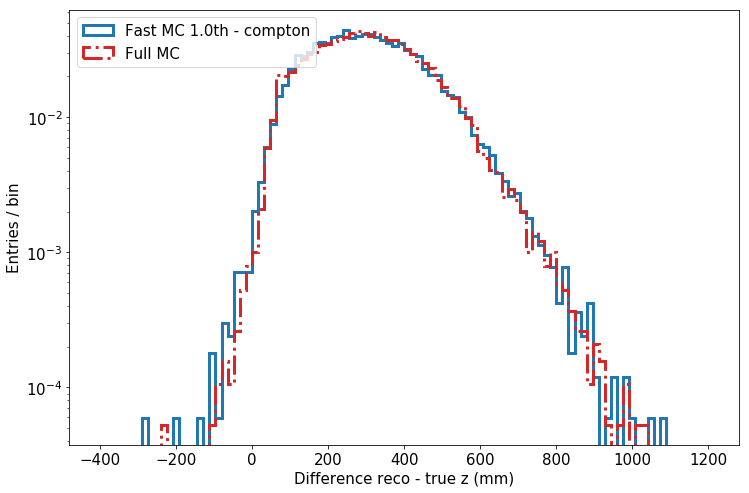

In [178]:
bins = 100
full1 = reco_t2_1 - true_t2
fast1 = reco_t2_compt_fast_1 - true_t2_compt_fast_1

bins1 = np.histogram(np.hstack((full1, fast1)), range=(-400,1200), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full  = get_weights(full1, True)
weights_fast1 = get_weights(fast1, True)

h0 = plt.hist(fast1, bins=bins1, color=colors[0], histtype='step', weights=weights_fast0,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1.0th - compton')
h1 = plt.hist(full1, bins=bins1, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

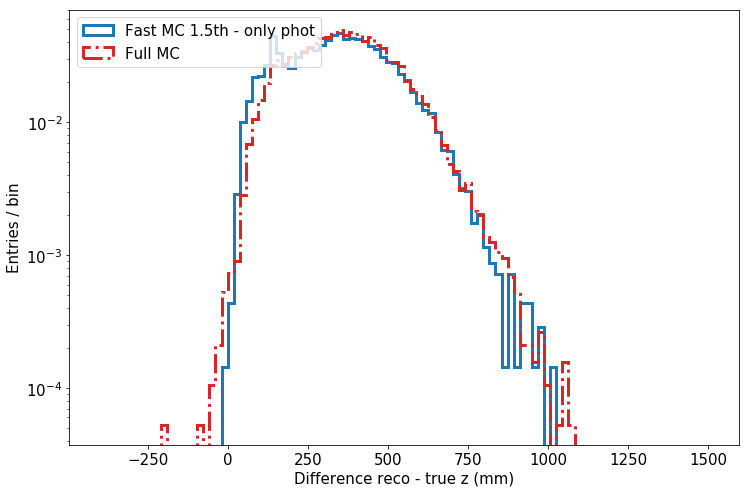

In [182]:
bins = 100
full2 = reco_t2_2 - true_t2
fast2 = reco_t2_phot_fast_2 - true_t2_phot_fast_2

bins2 = np.histogram(np.hstack((full2, fast2)), range=(-400,1500), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full  = get_weights(full2, True)
weights_fast2 = get_weights(fast2, True)

h0 = plt.hist(fast2, bins=bins2, color=colors[0], histtype='step', weights=weights_fast2,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1.5th - only phot')
h1 = plt.hist(full2, bins=bins2, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);

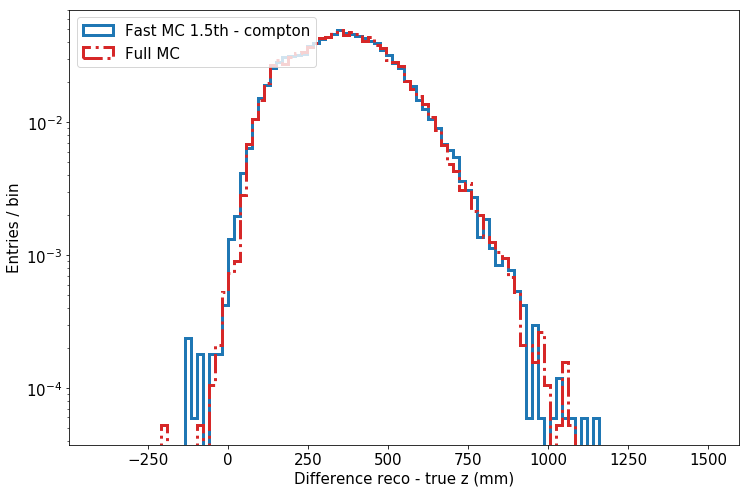

In [180]:
bins = 100
full2 = reco_t2_2 - true_t2
fast2 = reco_t2_compt_fast_2 - true_t2_compt_fast_2

bins2 = np.histogram(np.hstack((full2, fast2)), range=(-400,1500), bins=100)[1] #get the bin edges # range=(-150, 150)

weights_full  = get_weights(full2, True)
weights_fast2 = get_weights(fast2, True)

h0 = plt.hist(fast2, bins=bins2, color=colors[0], histtype='step', weights=weights_fast2,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[0], label='Fast MC 1.5th - compton')
h1 = plt.hist(full2, bins=bins2, color=colors[2], histtype='step', weights=weights_full,
         stacked=True, fill=False, linewidth=3.0, linestyle=linestyle[1], label='Full MC')
plt.xlabel('Difference reco - true z (mm)')
plt.ylabel('Entries / bin');
plt.yscale('log')
lnd = plt.legend(loc=2);